# Bibliotecas e Frameworks

In [78]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Carregar Dataset


In [2]:
root = '/home/alebex/pratica-dissertacao/Plano A/'
caminho = root+'aruba.csv'
caminho_original = root+'data'

# Dataset Original Gerar novo em CSV Corrigido

In [86]:
colunas = ['Data', 'Hora', 'Id_Sensor', 'Valor_Sensor', 'Label', 'Log']
df = pd.read_csv(caminho_original, header=None, sep='\s+', names=colunas)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719558 entries, 0 to 1719557
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Data          object
 1   Hora          object
 2   Id_Sensor     object
 3   Valor_Sensor  object
 4   Label         object
 5   Log           object
dtypes: object(6)
memory usage: 78.7+ MB


In [87]:
df['TimeStamp'] = pd.to_datetime(df['Data']+ " " +df['Hora'])

In [88]:
df = df[['TimeStamp','Data','Hora','Id_Sensor','Valor_Sensor','Label','Log']]

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719558 entries, 0 to 1719557
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   TimeStamp     datetime64[ns]
 1   Data          object        
 2   Hora          object        
 3   Id_Sensor     object        
 4   Valor_Sensor  object        
 5   Label         object        
 6   Log           object        
dtypes: datetime64[ns](1), object(6)
memory usage: 91.8+ MB


In [90]:
df.sort_values(by=['TimeStamp'],ascending=True,inplace=True)

In [91]:
len(df), max(df.index)

(1719558, 1719557)

## Remover Inconsistencias

O conjunto de celulas na presente tarefa demora mais de 30 minutos para executar devido ao volume de dados.

In [96]:
flag = False
rotulo = ''
for x in range(len(df)):
    if(df.iloc[x]['Log']=='begin'):
        flag = True
        rotulo = df.iloc[x]['Label']
    if(df.iloc[x]['Log']=='end'):
        flag = False
    
    if(flag and df.iloc[x]['Log'] != 'begin'):
        df.iloc[x, df.columns.get_loc('Label')] = rotulo

In [97]:
df.loc[df['Label'].isnull(), 'Label'] = 'zzero'

In [98]:
flag = False
rotulo = 'other'
for x in range(len(df)):
    if(df.iloc[x, df.columns.get_loc('Label')] == 'zzero'):
        if (df.iloc[x-1, df.columns.get_loc('Log')] == 'end'):
            df.iloc[x, df.columns.get_loc('Label')] = 'other'

In [99]:
df.loc[df['Label'] == 'other', 'Log'] = 'Ubegin'

### Remoção de sensor com valor que representa um outlier, o presente sensor não se encontra na planta

In [101]:
df[df['Id_Sensor'] == 'ENTERHOME']

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log
1530061,2011-05-18 14:12:13.738946,2011-05-18,14:12:13.738946,ENTERHOME,6592,Enter_Home,NaN


In [58]:
temp= df[df['Id_Sensor'] == 'ENTERHOME']['TimeStamp'].values[0]

In [77]:
max(df[df['Id_Sensor'].str[0]=='T']['Valor_Sensor'])

'43'

In [106]:
df[(df['TimeStamp'] > temp-pd.Timedelta('5 sec')) & (df['TimeStamp'] < temp+pd.Timedelta('5 sec'))]

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log
1530059,2011-05-18 14:12:12.278942,2011-05-18,14:12:12.278942,D004,OPEN,Enter_Home,begin
1530060,2011-05-18 14:12:13.376805,2011-05-18,14:12:13.376805,M030,ON,Enter_Home,NaN
1530061,2011-05-18 14:12:13.738946,2011-05-18,14:12:13.738946,ENTERHOME,6592,Enter_Home,NaN
1530062,2011-05-18 14:12:15.019207,2011-05-18,14:12:15.019207,M029,ON,Enter_Home,NaN
1530063,2011-05-18 14:12:18.072472,2011-05-18,14:12:18.072472,M030,OFF,Enter_Home,NaN
1530064,2011-05-18 14:12:18.157839,2011-05-18,14:12:18.157839,D004,CLOSE,Enter_Home,end
1530065,2011-05-18 14:12:18.266487,2011-05-18,14:12:18.266487,M028,ON,other,Ubegin


In [107]:
df[df['Label']=='Enter_Home'].tail(60)

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log
1685541,2011-06-07 12:55:53.954734,2011-06-07,12:55:53.954734,M030,OFF,Enter_Home,NaN
1685542,2011-06-07 12:55:54.555560,2011-06-07,12:55:54.55556,M029,ON,Enter_Home,NaN
1685543,2011-06-07 12:55:56.467248,2011-06-07,12:55:56.467248,D004,CLOSE,Enter_Home,end
1686178,2011-06-07 15:09:09.192105,2011-06-07,15:09:09.192105,D004,OPEN,Enter_Home,begin
1686179,2011-06-07 15:09:10.112987,2011-06-07,15:09:10.112987,M030,ON,Enter_Home,NaN
1686180,2011-06-07 15:09:15.339567,2011-06-07,15:09:15.339567,M030,OFF,Enter_Home,NaN
1686181,2011-06-07 15:09:20.552610,2011-06-07,15:09:20.55261,M030,ON,Enter_Home,NaN
1686182,2011-06-07 15:09:24.660303,2011-06-07,15:09:24.660303,M029,ON,Enter_Home,NaN
1686183,2011-06-07 15:09:25.722928,2011-06-07,15:09:25.722928,M028,ON,Enter_Home,NaN
1686184,2011-06-07 15:09:26.772919,2011-06-07,15:09:26.772919,M022,ON,Enter_Home,NaN


In [112]:
df.drop(df[df['Id_Sensor'] == 'ENTERHOME'].index[0], inplace=True)

### Sensor com nome inconsistente

In [108]:
df.loc[df['Id_Sensor']=='c', 'Id_Sensor'] = 'M014'

In [110]:
df[df['Id_Sensor']=='c']

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log


In [113]:
df.iloc[1476693]

TimeStamp       2011-05-10 18:42:45.169231
Data                            2011-05-10
Hora                       18:42:45.169231
Id_Sensor                             M014
Valor_Sensor                           OFF
Label                               Eating
Log                                    NaN
Name: 1476693, dtype: object

### Inconsistencias nos valores dos sensores

In [114]:
df.columns

Index(['TimeStamp', 'Data', 'Hora', 'Id_Sensor', 'Valor_Sensor', 'Label',
       'Log'],
      dtype='object')

In [122]:
lst_valores_sensor = df['Valor_Sensor'].unique()
lst_valores_sensor = sorted(lst_valores_sensor)

In [143]:
df.loc[df['Valor_Sensor']  == 'ONM026', 'Valor_Sensor'] = 'ON' 

In [125]:
lst_valores_sensor

['16',
 '16.5',
 '17',
 '17.5',
 '18',
 '18.5',
 '180',
 '19',
 '19.5',
 '19.55',
 '20',
 '20.5',
 '21',
 '21.5',
 '22',
 '22.5',
 '225',
 '23',
 '23.5',
 '23.555',
 '235',
 '24',
 '24.5',
 '245',
 '25',
 '25.5',
 '26',
 '26.5',
 '26cc',
 '27',
 '27.5',
 '28',
 '28.5',
 '28.55c',
 '285',
 '29',
 '29.5',
 '30',
 '30.5',
 '300',
 '31',
 '31.5',
 '32',
 '32.5',
 '33',
 '33.5',
 '34',
 '34.5',
 '35',
 '35.5',
 '36',
 '36.5',
 '37',
 '37.5',
 '38',
 '38.5',
 '39',
 '39.5',
 '40.5',
 '41.5',
 '42',
 '42.5',
 '43',
 'CLOSE',
 'CLOSED',
 'O',
 'OF',
 'OFF',
 'OFF5',
 'OFF5c',
 'OFF5cc',
 'OFFc',
 'OFFc5',
 'OFFcc',
 'OFFccc5',
 'OFcF',
 'ON',
 'ON5',
 'ON55',
 'ON5c',
 'ONM009',
 'ONM024',
 'ONc',
 'ONc5',
 'ONc5c',
 'ONcc',
 'OPEN',
 'OPENc',
 'OcFF']

In [128]:
for x,y in enumerate(lst_valores_sensor):
    try:
        if(y == 'CLOSE'):
            print(x)
            break
    except:
        print(x)

63


In [131]:
lst_valores_cat = lst_valores_sensor[63:]

In [140]:
df[df['Valor_Sensor'] == 'O']

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log
886911,2011-02-23 15:28:52.875123,2011-02-23,15:28:52.875123,M009,O,Relax,begin


In [153]:
# Corrigir valores categoricos nos sensores
for x in lst_valores_cat:
    if(x == 'O'):
        df.loc[df['Valor_Sensor']  == x, 'Valor_Sensor'] = 'OFF'
    elif((x[:2].lower() == 'of' or x[:2].lower() == 'oc') and x != 'OFF'):
        df.loc[df['Valor_Sensor']  == x, 'Valor_Sensor'] = 'OFF'
    elif (x[:2].lower() == 'on' and x != 'ON'):
        df.loc[df['Valor_Sensor']  == x, 'Valor_Sensor'] = 'ON'
    elif (x[:2].lower() == 'op' and x != 'OPEN'):
        df.loc[df['Valor_Sensor']  == x, 'Valor_Sensor'] = 'OPEN'
    elif (x[:2].lower() == 'cl' and x != 'CLOSE'):
        df.loc[df['Valor_Sensor']  == x, 'Valor_Sensor'] = 'CLOSE'

In [154]:
df['Valor_Sensor'].unique()

array(['ON', 'OFF', '21.5', '21', '20.5', '20', '19.5', '19', '18.5',
       '26.5', '23', '22.5', '23.5', '22', '24.5', '25', '28', '30.5',
       '27', '26', '32', '28.5', '27.5', '24', '33', '29.5', '29', '34',
       '30', '34.5', '31.5', '25.5', '35', '36', '36.5', '32.5', '37',
       '33.5', 'OPEN', 'CLOSE', '37.5', '31', '35.5', '38', '38.5', '39',
       '18', '17.5', '17', '39.5', '16.5', '16', '28.55c', '26cc', '285',
       '19.55', '245', '225', '23.555', '235', '42', '41.5', '42.5', '43',
       '40.5', '180', '300'], dtype=object)

In [155]:
df.iloc[886911]

TimeStamp       2011-02-23 15:28:52.875123
Data                            2011-02-23
Hora                       15:28:52.875123
Id_Sensor                             M009
Valor_Sensor                           OFF
Label                                Relax
Log                                  begin
Name: 886911, dtype: object

## Guardar Dataset em formato mais adequado

Comentei pq só faz sentido executar essa celula, quando a de cima tbm é executada.

In [152]:

#df.to_csv('/home/alebex/pratica-dissertacao/Plano A/aruba.csv', index=False)

# Carregar DataSet v.1 em CSV

In [24]:
df = pd.read_csv(caminho)
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719557 entries, 0 to 1719556
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   TimeStamp     datetime64[ns]
 1   Data          object        
 2   Hora          object        
 3   Id_Sensor     object        
 4   Valor_Sensor  object        
 5   Label         object        
 6   Log           object        
dtypes: datetime64[ns](1), object(6)
memory usage: 91.8+ MB


In [25]:
len(df['Valor_Sensor'].unique())

68

In [7]:
df

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log
0,2010-11-04 00:03:50.209589,2010-11-04,00:03:50.209589,M003,ON,Sleeping,begin
1,2010-11-04 00:03:57.399391,2010-11-04,00:03:57.399391,M003,OFF,Sleeping,NaN
2,2010-11-04 00:15:08.984841,2010-11-04,00:15:08.984841,T002,21.5,Sleeping,NaN
3,2010-11-04 00:30:19.185547,2010-11-04,00:30:19.185547,T003,21,Sleeping,NaN
4,2010-11-04 00:30:19.385336,2010-11-04,00:30:19.385336,T004,21,Sleeping,NaN
...,...,...,...,...,...,...,...
1719552,2011-06-11 23:42:59.285070,2011-06-11,23:42:59.28507,T002,25.5,Sleeping,NaN
1719553,2011-06-11 23:48:02.888409,2011-06-11,23:48:02.888409,T001,23.5,Sleeping,NaN
1719554,2011-06-11 23:48:02.988798,2011-06-11,23:48:02.988798,T002,25,Sleeping,NaN
1719555,2011-06-11 23:53:06.429200,2011-06-11,23:53:06.4292,T002,25.5,Sleeping,NaN


In [26]:
df[df['Label'] == 'zzero']

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log
50,2010-11-04 05:40:45.939846,2010-11-04,05:40:45.939846,M005,ON,zzero,NaN
51,2010-11-04 05:40:46.310862,2010-11-04,05:40:46.310862,M003,OFF,zzero,NaN
65,2010-11-04 05:43:35.941892,2010-11-04,05:43:35.941892,M007,OFF,zzero,NaN
66,2010-11-04 05:43:40.821615,2010-11-04,05:43:40.821615,M007,ON,zzero,NaN
67,2010-11-04 05:43:45.619681,2010-11-04,05:43:45.619681,M007,OFF,zzero,NaN
...,...,...,...,...,...,...,...
1719494,2011-06-11 22:10:10.734616,2011-06-11,22:10:10.734616,M007,ON,zzero,NaN
1719495,2011-06-11 22:10:12.185314,2011-06-11,22:10:12.185314,M004,OFF,zzero,NaN
1719496,2011-06-11 22:10:13.263357,2011-06-11,22:10:13.263357,M005,ON,zzero,NaN
1719497,2011-06-11 22:10:17.045615,2011-06-11,22:10:17.045615,M005,OFF,zzero,NaN


In [9]:
df[df['Label'] == 'other']

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log
49,2010-11-04 05:40:44.223548,2010-11-04,05:40:44.223548,M003,ON,other,Ubegin
64,2010-11-04 05:43:34.261135,2010-11-04,05:43:34.261135,M005,OFF,other,Ubegin
173,2010-11-04 08:01:16.512483,2010-11-04,08:01:16.512483,M007,OFF,other,Ubegin
521,2010-11-04 08:27:06.795729,2010-11-04,08:27:06.795729,M020,OFF,other,Ubegin
708,2010-11-04 08:35:46.861464,2010-11-04,08:35:46.861464,M019,OFF,other,Ubegin
...,...,...,...,...,...,...,...
1718676,2011-06-11 17:57:51.553680,2011-06-11,17:57:51.55368,M020,OFF,other,Ubegin
1718826,2011-06-11 18:14:30.935729,2011-06-11,18:14:30.935729,M014,ON,other,Ubegin
1719050,2011-06-11 20:33:45.503282,2011-06-11,20:33:45.503282,M013,ON,other,Ubegin
1719347,2011-06-11 21:18:12.297397,2011-06-11,21:18:12.297397,M013,OFF,other,Ubegin


In [161]:
classe_por_atividade = pd.Series({
        'Meal_Preparation': 1606,
        'Relax':2910,
        'Eating':257,
        'Work':171,
        'Sleeping':401,
        'Wash_Dishes':65,
        'Bed_to_Toilet':157,
        'Enter_Home':431,
        'Leave_Home':431,
        'Housekeeping':33,
        'Resperate':6
})

In [27]:
print('Quantidade de atividades desconhecidas:'+str(len(df[df['Log'] == 'Ubegin'])))

Quantidade de atividades desconhecidas:6354


# Balanceamento completo

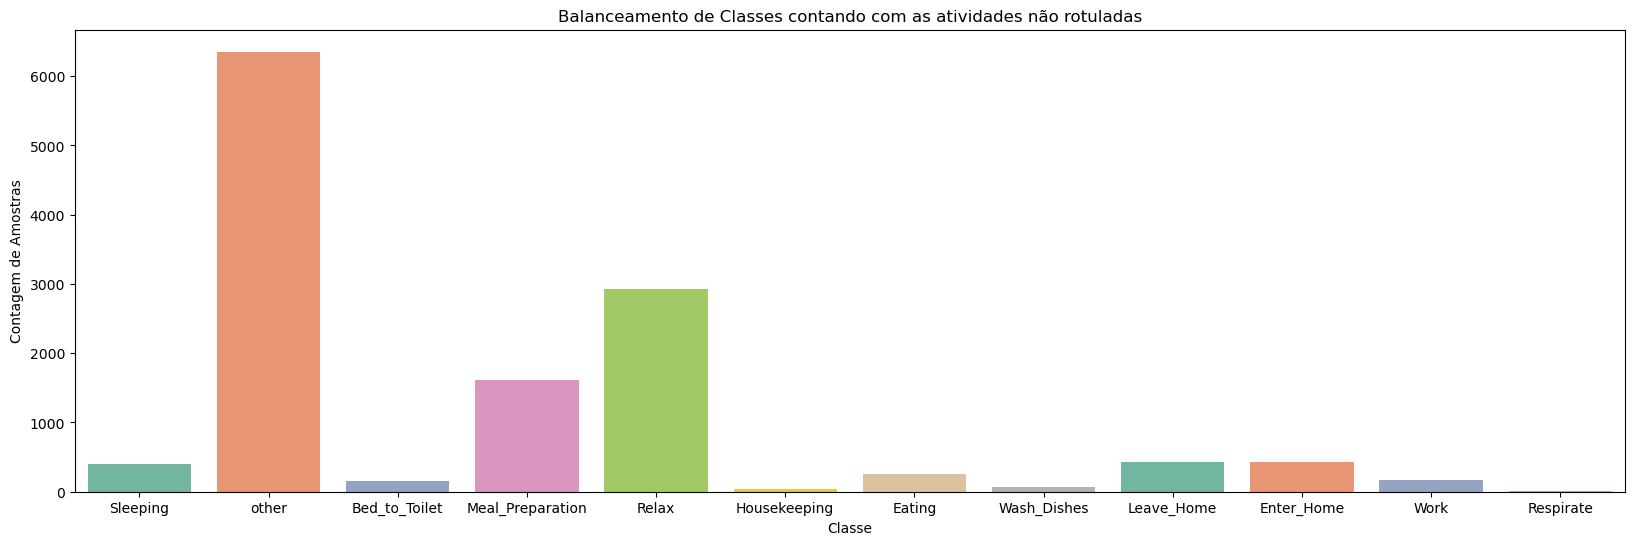

In [163]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df[(df['Log'] == 'begin') | (df['Log'] == 'Ubegin')], x='Label', palette='Set2')
plt.title('Balanceamento de Classes contando com as atividades não rotuladas')
plt.xlabel('Classe')
plt.ylabel('Contagem de Amostras')
plt.show()

# Eliminar eventos desconhecidos

In [28]:
df = df[(df['Label'] != 'zzero') & (df['Label'] != 'other')]

In [29]:
df

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log
0,2010-11-04 00:03:50.209589,2010-11-04,00:03:50.209589,M003,ON,Sleeping,begin
1,2010-11-04 00:03:57.399391,2010-11-04,00:03:57.399391,M003,OFF,Sleeping,NaN
2,2010-11-04 00:15:08.984841,2010-11-04,00:15:08.984841,T002,21.5,Sleeping,NaN
3,2010-11-04 00:30:19.185547,2010-11-04,00:30:19.185547,T003,21,Sleeping,NaN
4,2010-11-04 00:30:19.385336,2010-11-04,00:30:19.385336,T004,21,Sleeping,NaN
...,...,...,...,...,...,...,...
1719552,2011-06-11 23:42:59.285070,2011-06-11,23:42:59.28507,T002,25.5,Sleeping,NaN
1719553,2011-06-11 23:48:02.888409,2011-06-11,23:48:02.888409,T001,23.5,Sleeping,NaN
1719554,2011-06-11 23:48:02.988798,2011-06-11,23:48:02.988798,T002,25,Sleeping,NaN
1719555,2011-06-11 23:53:06.429200,2011-06-11,23:53:06.4292,T002,25.5,Sleeping,NaN


In [30]:
df.reset_index(drop=True, inplace=True)

In [31]:
df

,TimeStamp,Data,Hora,Id_Sensor,Valor_Sensor,Label,Log
0,2010-11-04 00:03:50.209589,2010-11-04,00:03:50.209589,M003,ON,Sleeping,begin
1,2010-11-04 00:03:57.399391,2010-11-04,00:03:57.399391,M003,OFF,Sleeping,NaN
2,2010-11-04 00:15:08.984841,2010-11-04,00:15:08.984841,T002,21.5,Sleeping,NaN
3,2010-11-04 00:30:19.185547,2010-11-04,00:30:19.185547,T003,21,Sleeping,NaN
4,2010-11-04 00:30:19.385336,2010-11-04,00:30:19.385336,T004,21,Sleeping,NaN
...,...,...,...,...,...,...,...
792594,2011-06-11 23:42:59.285070,2011-06-11,23:42:59.28507,T002,25.5,Sleeping,NaN
792595,2011-06-11 23:48:02.888409,2011-06-11,23:48:02.888409,T001,23.5,Sleeping,NaN
792596,2011-06-11 23:48:02.988798,2011-06-11,23:48:02.988798,T002,25,Sleeping,NaN
792597,2011-06-11 23:53:06.429200,2011-06-11,23:53:06.4292,T002,25.5,Sleeping,NaN


# Balanceamento somente das atividades conhecidas

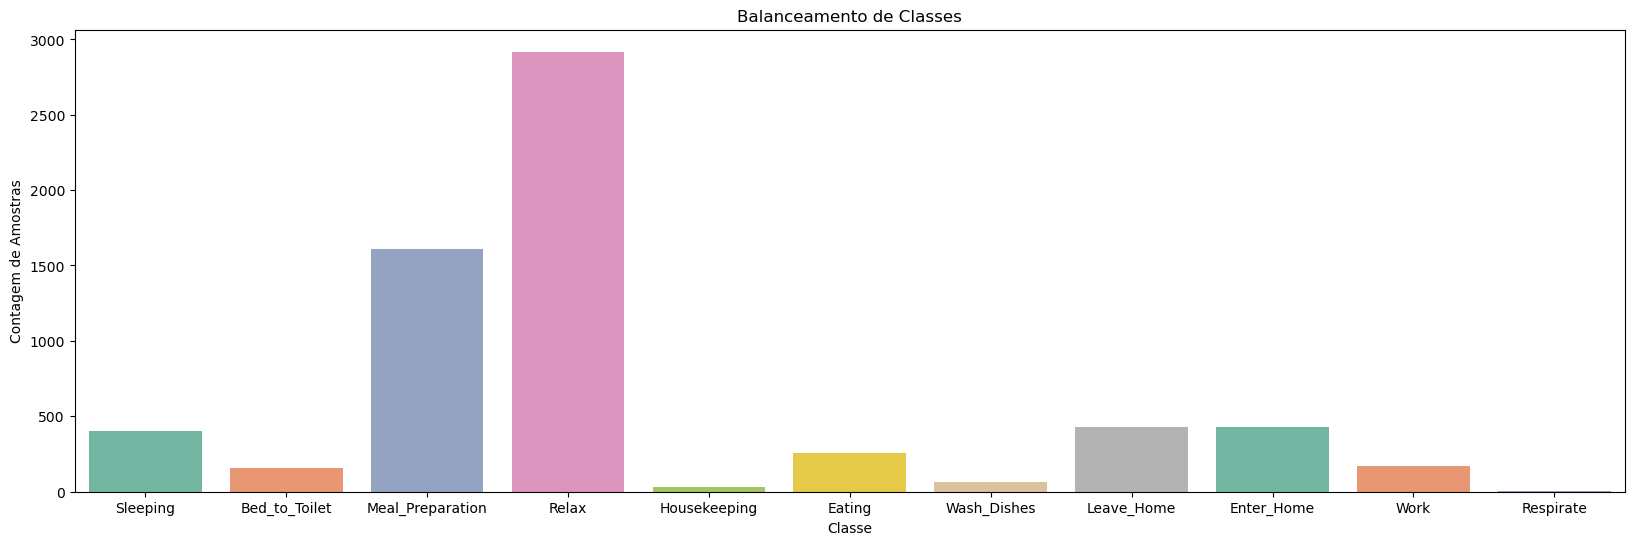

In [201]:
plt.figure(figsize=(20, 6))
sns.countplot(data=df[(df['Log'] == 'begin')], x='Label', palette='Set2')
plt.title('Balanceamento de Classes')
plt.xlabel('Classe')
plt.ylabel('Contagem de Amostras')
plt.show()

# Lista de Sensores unicos

In [32]:
lista_de_sensores = sorted(df.Id_Sensor.unique().astype(str))
lista_de_sensores

['D001',
 'D002',
 'D004',
 'M001',
 'M002',
 'M003',
 'M004',
 'M005',
 'M006',
 'M007',
 'M008',
 'M009',
 'M010',
 'M011',
 'M012',
 'M013',
 'M014',
 'M015',
 'M016',
 'M017',
 'M018',
 'M019',
 'M020',
 'M021',
 'M022',
 'M023',
 'M024',
 'M025',
 'M026',
 'M027',
 'M028',
 'M029',
 'M030',
 'M031',
 'T001',
 'T002',
 'T003',
 'T004',
 'T005']

# Lista de atividades

In [33]:
lista_de_atividades = sorted(df['Label'].astype('str').unique())

In [34]:
lista_de_atividades

['Bed_to_Toilet',
 'Eating',
 'Enter_Home',
 'Housekeeping',
 'Leave_Home',
 'Meal_Preparation',
 'Relax',
 'Respirate',
 'Sleeping',
 'Wash_Dishes',
 'Work']

# Apagar Colunas desnecessarias

In [6]:
len((df['Valor_Sensor'] == 'ON') | (df['Valor_Sensor'] == 'OFF')) == len(df)

True

In [35]:
df.drop(['Data','Hora'], axis=1, inplace=True)

In [36]:
df

,TimeStamp,Id_Sensor,Valor_Sensor,Label,Log
0,2010-11-04 00:03:50.209589,M003,ON,Sleeping,begin
1,2010-11-04 00:03:57.399391,M003,OFF,Sleeping,NaN
2,2010-11-04 00:15:08.984841,T002,21.5,Sleeping,NaN
3,2010-11-04 00:30:19.185547,T003,21,Sleeping,NaN
4,2010-11-04 00:30:19.385336,T004,21,Sleeping,NaN
...,...,...,...,...,...
792594,2011-06-11 23:42:59.285070,T002,25.5,Sleeping,NaN
792595,2011-06-11 23:48:02.888409,T001,23.5,Sleeping,NaN
792596,2011-06-11 23:48:02.988798,T002,25,Sleeping,NaN
792597,2011-06-11 23:53:06.429200,T002,25.5,Sleeping,NaN


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792599 entries, 0 to 792598
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   TimeStamp     792599 non-null  datetime64[ns]
 1   Id_Sensor     792599 non-null  object        
 2   Valor_Sensor  792599 non-null  object        
 3   Label         792599 non-null  object        
 4   Log           12954 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 30.2+ MB


In [38]:
max(df['TimeStamp']), min(df['TimeStamp'])

(Timestamp('2011-06-11 23:58:10.004834'),
 Timestamp('2010-11-04 00:03:50.209589'))

In [39]:
df.columns

Index(['TimeStamp', 'Id_Sensor', 'Valor_Sensor', 'Label', 'Log'], dtype='object')

# Resolver Temperatura com valores Inconsistentes

In [40]:
df.loc[df['Valor_Sensor'] == '28.55c', 'Valor_Sensor'] = float(28.55)
df.loc[df['Valor_Sensor'] == '28.26cc', 'Valor_Sensor'] = float(28.26)
df.loc[df['Valor_Sensor'] == '26cc', 'Valor_Sensor'] = float(26)

In [41]:
df.loc[df['Id_Sensor'].str[0] == 'T', 'Valor_Sensor'] = df[df['Id_Sensor'].str[0] == 'T'].apply(lambda x: pd.to_numeric(x['Valor_Sensor']) , axis=1)

# Transformar Valores de Sensores de categoricos para numerico

In [42]:
df.loc[df['Valor_Sensor'].isin(['ON','OPEN']), 'Valor_Sensor'] = int(1)

In [43]:
df.loc[df['Valor_Sensor'].isin(['OFF','CLOSE']), 'Valor_Sensor'] = int(0)

In [44]:
df

,TimeStamp,Id_Sensor,Valor_Sensor,Label,Log
0,2010-11-04 00:03:50.209589,M003,1,Sleeping,begin
1,2010-11-04 00:03:57.399391,M003,0,Sleeping,NaN
2,2010-11-04 00:15:08.984841,T002,21.5,Sleeping,NaN
3,2010-11-04 00:30:19.185547,T003,21.0,Sleeping,NaN
4,2010-11-04 00:30:19.385336,T004,21.0,Sleeping,NaN
...,...,...,...,...,...
792594,2011-06-11 23:42:59.285070,T002,25.5,Sleeping,NaN
792595,2011-06-11 23:48:02.888409,T001,23.5,Sleeping,NaN
792596,2011-06-11 23:48:02.988798,T002,25.0,Sleeping,NaN
792597,2011-06-11 23:53:06.429200,T002,25.5,Sleeping,NaN


# Analisar a Temperatura

In [45]:
df[(df['Id_Sensor'].str[0] == 'T') & ((df['Log'] == 'begin') | (df['Log'] == 'end'))]

,TimeStamp,Id_Sensor,Valor_Sensor,Label,Log
792598,2011-06-11 23:58:10.004834,T002,25.0,Sleeping,end


In [46]:
df.Valor_Sensor = pd.to_numeric(df.Valor_Sensor)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792599 entries, 0 to 792598
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   TimeStamp     792599 non-null  datetime64[ns]
 1   Id_Sensor     792599 non-null  object        
 2   Valor_Sensor  792599 non-null  float64       
 3   Label         792599 non-null  object        
 4   Log           12954 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 30.2+ MB


In [51]:
df_temperatura = df[df['Id_Sensor'].str[0] == 'T'].copy()

In [48]:
len(df)

792599

In [49]:
df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'].describe()

count    73275.000000
mean        22.609671
std          3.458539
min         16.000000
25%         20.500000
50%         22.500000
75%         24.500000
max        285.000000
Name: Valor_Sensor, dtype: float64

In [118]:
max(df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'])

285.0

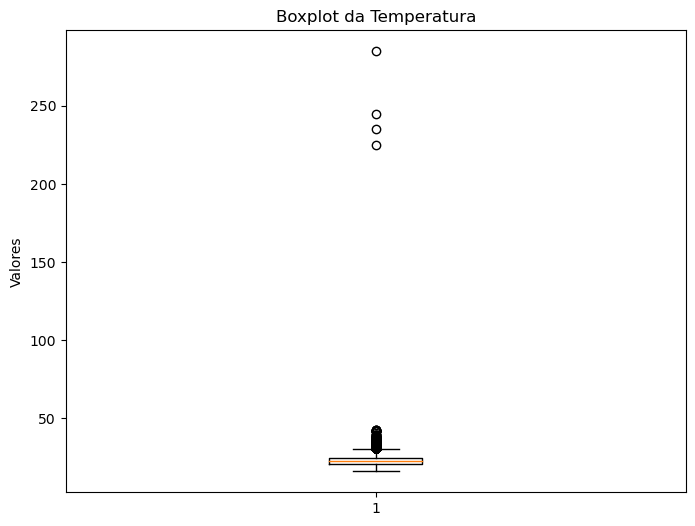

In [110]:
plt.figure(figsize=(8, 6))  
plt.boxplot(df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'])  
plt.title('Boxplot da Temperatura') 
plt.ylabel('Valores')  
plt.show()

In [36]:
gp_T = df_temperatura.groupby(by='Label')

In [164]:
gp_T['Valor_Sensor'].mean()

Label
Bed_to_Toilet       21.019608
Eating              24.947389
Enter_Home          22.107143
Housekeeping        25.351190
Leave_Home          24.113636
Meal_Preparation    24.158683
Relax               23.708782
Respirate           23.413793
Sleeping            20.934143
Wash_Dishes         25.013761
Work                24.333587
Name: Valor_Sensor, dtype: float64

In [166]:
gp_T['Valor_Sensor'].min()

Label
Bed_to_Toilet       17.0
Eating              18.0
Enter_Home          18.0
Housekeeping        19.0
Leave_Home          22.5
Meal_Preparation    16.5
Relax               16.0
Respirate           21.0
Sleeping            16.5
Wash_Dishes         18.5
Work                17.0
Name: Valor_Sensor, dtype: float64

In [167]:
gp_T['Valor_Sensor'].max()

Label
Bed_to_Toilet        27.5
Eating               42.0
Enter_Home           25.0
Housekeeping         39.0
Leave_Home           26.5
Meal_Preparation    285.0
Relax               245.0
Respirate            27.0
Sleeping             34.5
Wash_Dishes          34.5
Work                 37.0
Name: Valor_Sensor, dtype: float64

In [168]:
gp_T['Valor_Sensor'].median()

Label
Bed_to_Toilet       21.00
Eating              24.50
Enter_Home          22.75
Housekeeping        24.50
Leave_Home          24.00
Meal_Preparation    23.50
Relax               23.50
Respirate           23.00
Sleeping            20.50
Wash_Dishes         24.75
Work                24.00
Name: Valor_Sensor, dtype: float64

In [52]:
df_temperatura[df_temperatura['Valor_Sensor'] == 285]['Valor_Sensor'].index

Index([110929], dtype='int64')

In [62]:
pd.Series(15)

0    15
dtype: int64

In [70]:
def solTemp(a):
    #return pd.Series(float(str(a.values[0])[:2]+'.'+str(a.values[0])[2]))
    return float(str(a)[:2]+'.'+str(a)[2]) 

In [53]:
Q1 = df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'].quantile(0.25)
Q3 = df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'].quantile(0.75)

# Intervalo interquartil (IQR)
IQR = Q3 - Q1

# Os limites superior e inferior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


# Remover
#df = df[df['Id_Sensor'].str[0] == 'T'][(df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'] >= limite_inferior) & (df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'] <= limite_superior)]

In [54]:
df[(df['Id_Sensor'].str[0]=='T') & ((df['Valor_Sensor'] > limite_superior) | (df['Valor_Sensor'] < limite_inferior))].sort_values(by='Valor_Sensor', ascending=False)

,TimeStamp,Id_Sensor,Valor_Sensor,Label,Log
110929,2010-12-13 12:38:55.759074,T002,285.0,Meal_Preparation,NaN
130705,2010-12-18 20:32:58.686535,T002,245.0,Relax,NaN
131276,2010-12-18 23:55:11.163266,T003,235.0,Relax,NaN
131031,2010-12-18 22:09:01.764377,T001,225.0,Relax,NaN
591895,2011-04-14 16:51:06.799245,T003,42.5,Relax,NaN
...,...,...,...,...,...
95679,2010-12-07 15:36:13.848330,T005,31.0,Meal_Preparation,NaN
95320,2010-12-07 10:22:47.400726,T005,31.0,Eating,NaN
413579,2011-02-28 14:44:46.623714,T005,31.0,Relax,NaN
88389,2010-12-05 00:09:32.648250,T005,31.0,Sleeping,NaN


In [55]:
for i, row in df[(df['Id_Sensor'].str[0]=='T') & ((df['Valor_Sensor'] > limite_superior) | (df['Valor_Sensor'] < limite_inferior))].iterrows():
    if(row['Valor_Sensor']>100):
        df.iloc[i, df.columns.get_loc('Valor_Sensor')] = float(str(row['Valor_Sensor'])[:2]+'.'+str(row['Valor_Sensor'])[2])
    elif(row['Valor_Sensor']>=31):
        df.iloc[i, df.columns.get_loc('Valor_Sensor')] = df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'].median()
    #elif(row['Valor_Sensor']==31):
    #    if((row['TimeStamp'].dt.month > 9 and row['TimeStamp'].dt.month <= 12) or row['TimeStamp'].dt.month == 1):
    #        df.iloc[i, df.columns.get_loc('Valor_Sensor')] = df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'].median()

In [56]:
df[(df['Id_Sensor'].str[0]=='T') & ((df['Valor_Sensor'] > limite_superior) | (df['Valor_Sensor'] < limite_inferior))].sort_values(by='Id_Sensor', ascending=False)

,TimeStamp,Id_Sensor,Valor_Sensor,Label,Log


In [57]:
gp_T = df[df['Id_Sensor'].str[0] == 'T'].groupby(by='Label')

In [58]:
gp_T['Valor_Sensor'].median()

Label
Bed_to_Toilet       21.00
Eating              24.00
Enter_Home          22.75
Housekeeping        24.00
Leave_Home          24.00
Meal_Preparation    23.50
Relax               23.50
Respirate           23.00
Sleeping            20.50
Wash_Dishes         24.50
Work                24.00
Name: Valor_Sensor, dtype: float64

In [59]:
df[df['Id_Sensor'].str[0] == 'T']['Valor_Sensor'].describe()

count    73275.000000
mean        22.445215
std          2.755013
min         16.000000
25%         20.500000
50%         22.500000
75%         24.000000
max         30.500000
Name: Valor_Sensor, dtype: float64

# Carregar Dataset com Tratamento antes da divisão

In [62]:
#df.to_csv('df_preEncode.csv', index=False)

In [3]:
df = pd.read_csv('df_preEncode.csv')
df.TimeStamp = pd.to_datetime(df.TimeStamp)

In [29]:
df

,TimeStamp,Id_Sensor,Valor_Sensor,Label,Log
0,2010-11-04 00:03:50.209589,M003,1.0,Sleeping,begin
1,2010-11-04 00:03:57.399391,M003,0.0,Sleeping,NaN
2,2010-11-04 00:15:08.984841,T002,21.5,Sleeping,NaN
3,2010-11-04 00:30:19.185547,T003,21.0,Sleeping,NaN
4,2010-11-04 00:30:19.385336,T004,21.0,Sleeping,NaN
...,...,...,...,...,...
792594,2011-06-11 23:42:59.285070,T002,25.5,Sleeping,NaN
792595,2011-06-11 23:48:02.888409,T001,23.5,Sleeping,NaN
792596,2011-06-11 23:48:02.988798,T002,25.0,Sleeping,NaN
792597,2011-06-11 23:53:06.429200,T002,25.5,Sleeping,NaN


In [10]:
#df_nn = df.copy()

# Encode pre-divisao

## Label encode Id Sensor

In [4]:
encoder_id = LabelEncoder()

df['Id_Sensor'] = encoder_id.fit_transform(df['Id_Sensor'])

## One Hor Id_sensor opcao 2

In [31]:
encoder = OneHotEncoder(sparse=False)

In [32]:
encoder.fit(df[['Id_Sensor']])

# Transformar a feature_alvo em codificação one-hot
feature_encoded = encoder.transform(df[['Id_Sensor']])

/home/alebex/anaconda3/envs/DissertacaoCmDeepConfig/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
encoded_df_id = pd.DataFrame(feature_encoded, columns=encoder.get_feature_names_out())
encoded_df_id

,Id_Sensor_D001,Id_Sensor_D002,Id_Sensor_D004,Id_Sensor_M001,Id_Sensor_M002,Id_Sensor_M003,Id_Sensor_M004,Id_Sensor_M005,Id_Sensor_M006,Id_Sensor_M007,...,Id_Sensor_M027,Id_Sensor_M028,Id_Sensor_M029,Id_Sensor_M030,Id_Sensor_M031,Id_Sensor_T001,Id_Sensor_T002,Id_Sensor_T003,Id_Sensor_T004,Id_Sensor_T005
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
792595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
792596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
792597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
df.columns

Index(['TimeStamp', 'Id_Sensor', 'Valor_Sensor', 'Label', 'Log'], dtype='object')

In [35]:

colum = ['TimeStamp'] + sorted(encoder.get_feature_names_out()) + ['Id_Sensor','Valor_Sensor', 'Label', 'Log']

In [36]:
df = pd.concat([df, encoded_df_id], axis=1)
df

,TimeStamp,Id_Sensor,Valor_Sensor,Label,Log,Id_Sensor_D001,Id_Sensor_D002,Id_Sensor_D004,Id_Sensor_M001,Id_Sensor_M002,...,Id_Sensor_M027,Id_Sensor_M028,Id_Sensor_M029,Id_Sensor_M030,Id_Sensor_M031,Id_Sensor_T001,Id_Sensor_T002,Id_Sensor_T003,Id_Sensor_T004,Id_Sensor_T005
0,2010-11-04 00:03:50.209589,M003,1.0,Sleeping,begin,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-11-04 00:03:57.399391,M003,0.0,Sleeping,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-11-04 00:15:08.984841,T002,21.5,Sleeping,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2010-11-04 00:30:19.185547,T003,21.0,Sleeping,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2010-11-04 00:30:19.385336,T004,21.0,Sleeping,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792594,2011-06-11 23:42:59.285070,T002,25.5,Sleeping,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
792595,2011-06-11 23:48:02.888409,T001,23.5,Sleeping,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
792596,2011-06-11 23:48:02.988798,T002,25.0,Sleeping,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
792597,2011-06-11 23:53:06.429200,T002,25.5,Sleeping,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
df = df[['TimeStamp',
 'Id_Sensor_D001',
 'Id_Sensor_D002',
 'Id_Sensor_D004',
 'Id_Sensor_M001',
 'Id_Sensor_M002',
 'Id_Sensor_M003',
 'Id_Sensor_M004',
 'Id_Sensor_M005',
 'Id_Sensor_M006',
 'Id_Sensor_M007',
 'Id_Sensor_M008',
 'Id_Sensor_M009',
 'Id_Sensor_M010',
 'Id_Sensor_M011',
 'Id_Sensor_M012',
 'Id_Sensor_M013',
 'Id_Sensor_M014',
 'Id_Sensor_M015',
 'Id_Sensor_M016',
 'Id_Sensor_M017',
 'Id_Sensor_M018',
 'Id_Sensor_M019',
 'Id_Sensor_M020',
 'Id_Sensor_M021',
 'Id_Sensor_M022',
 'Id_Sensor_M023',
 'Id_Sensor_M024',
 'Id_Sensor_M025',
 'Id_Sensor_M026',
 'Id_Sensor_M027',
 'Id_Sensor_M028',
 'Id_Sensor_M029',
 'Id_Sensor_M030',
 'Id_Sensor_M031',
 'Id_Sensor_T001',
 'Id_Sensor_T002',
 'Id_Sensor_T003',
 'Id_Sensor_T004',
 'Id_Sensor_T005',
 'Valor_Sensor', 
 'Label', 
 'Log']]

In [38]:
df

,TimeStamp,Id_Sensor_D001,Id_Sensor_D002,Id_Sensor_D004,Id_Sensor_M001,Id_Sensor_M002,Id_Sensor_M003,Id_Sensor_M004,Id_Sensor_M005,Id_Sensor_M006,...,Id_Sensor_M030,Id_Sensor_M031,Id_Sensor_T001,Id_Sensor_T002,Id_Sensor_T003,Id_Sensor_T004,Id_Sensor_T005,Valor_Sensor,Label,Log
0,2010-11-04 00:03:50.209589,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Sleeping,begin
1,2010-11-04 00:03:57.399391,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sleeping,NaN
2,2010-11-04 00:15:08.984841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,21.5,Sleeping,NaN
3,2010-11-04 00:30:19.185547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,21.0,Sleeping,NaN
4,2010-11-04 00:30:19.385336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,21.0,Sleeping,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792594,2011-06-11 23:42:59.285070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25.5,Sleeping,NaN
792595,2011-06-11 23:48:02.888409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.5,Sleeping,NaN
792596,2011-06-11 23:48:02.988798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25.0,Sleeping,NaN
792597,2011-06-11 23:53:06.429200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25.5,Sleeping,NaN


In [39]:
len(df.columns)

43

## Target encode

In [ ]:
len(lista_de_sensores)

In [5]:
encoder_label = LabelEncoder()

df['Label'] = encoder_label.fit_transform(df['Label'])
#df_nn['Label'] = df['Label']

In [32]:
df

,TimeStamp,Id_Sensor,Valor_Sensor,Label,Log
0,2010-11-04 00:03:50.209589,5,1.0,8,begin
1,2010-11-04 00:03:57.399391,5,0.0,8,NaN
2,2010-11-04 00:15:08.984841,35,21.5,8,NaN
3,2010-11-04 00:30:19.185547,36,21.0,8,NaN
4,2010-11-04 00:30:19.385336,37,21.0,8,NaN
...,...,...,...,...,...
792594,2011-06-11 23:42:59.285070,35,25.5,8,NaN
792595,2011-06-11 23:48:02.888409,34,23.5,8,NaN
792596,2011-06-11 23:48:02.988798,35,25.0,8,NaN
792597,2011-06-11 23:53:06.429200,35,25.5,8,NaN


In [219]:
#df_nn

,TimeStamp,Id_Sensor,Valor_Sensor,Label,Log
0,2010-11-04 00:03:50.209589,M003,1.0,8,begin
1,2010-11-04 00:03:57.399391,M003,0.0,8,NaN
2,2010-11-04 00:15:08.984841,T002,21.5,8,NaN
3,2010-11-04 00:30:19.185547,T003,21.0,8,NaN
4,2010-11-04 00:30:19.385336,T004,21.0,8,NaN
...,...,...,...,...,...
792594,2011-06-11 23:42:59.285070,T002,25.5,8,NaN
792595,2011-06-11 23:48:02.888409,T001,23.5,8,NaN
792596,2011-06-11 23:48:02.988798,T002,25.0,8,NaN
792597,2011-06-11 23:53:06.429200,T002,25.5,8,NaN


# Dataset com o inicio e fim de cada atividade

# Divisao Treino e Teste

In [6]:
df_act = pd.read_csv('df_act_Completo.csv')
df_act.end_time = pd.to_datetime(df_act.end_time)
df_act.start_time = pd.to_datetime(df_act.start_time)

In [34]:
df_act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6477 entries, 0 to 6476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   start_time  6477 non-null   datetime64[ns]
 1   end_time    6477 non-null   datetime64[ns]
 2   Label       6477 non-null   object        
dtypes: datetime64[ns](2), object(1)
memory usage: 151.9+ KB


In [7]:
train_df = df[df['TimeStamp']<= pd.to_datetime('2011-04-01')]
test_df = df[df['TimeStamp'] > pd.to_datetime('2011-04-01')]
test_df.reset_index(drop=True, inplace=True)
tm = max(train_df.TimeStamp)

In [8]:
encoder_label.classes_

array(['Bed_to_Toilet', 'Eating', 'Enter_Home', 'Housekeeping',
       'Leave_Home', 'Meal_Preparation', 'Relax', 'Respirate', 'Sleeping',
       'Wash_Dishes', 'Work'], dtype=object)

In [326]:
df[(df['TimeStamp']>=pd.to_datetime('2010-11-25 12:27:57.084447')) & (df['TimeStamp']<=pd.to_datetime('2010-11-25 12:28:01.606924'))][['Valor_Sensor','Label','Log','Label']]

,Valor_Sensor,Label,Log,Label
62227,1.0,2,begin,2
62228,1.0,2,NaN,2
62229,1.0,2,NaN,2
62230,0.0,2,end,2


In [144]:
#train_df.set_index('TimeStamp',inplace=True)
#test_df.set_index('TimeStamp', inplace=True)

In [75]:
#train_df.to_csv('train.csv', index=False)
#test_df.to_csv('test.csv', index=False)

# Criar os Segmentos

In [9]:
lst_features = sorted(df.columns)

In [10]:
lst_features.remove('TimeStamp')
lst_features.remove('Label')
lst_features.remove('Log')

In [ ]:
#lst_features

In [88]:
def criarSegmento(data):
    flag = False
    rotulo = None
    vec_event = []
    vec_rotulo = []
    seg_features = []
    for x in range(len(data)):
        if(data.iloc[x,data.columns.get_loc('Log')]=='begin'):
            flag = True
            rotulo = data.iloc[x,data.columns.get_loc('Label')]
        if(flag):
            for y in lst_features:
                seg_features.append(data.iloc[x,data.columns.get_loc(y)])
        if(data.iloc[x,data.columns.get_loc('Log')]=='end'):
            flag = False
            vec_event.append(seg_features)
            vec_rotulo.append(rotulo)
            seg_features = []
    return vec_event, vec_rotulo

## Segmentando com a funcao seg_nn Ideal para segmentacao

In [158]:
vec_event_train, vec_act_train = seg_nn(train_df, df_act[df_act['end_time']<=tm], flag=False)

In [159]:
vec_event_test, vec_act_test =  seg_nn(test_df, df_act[df_act['start_time']>=tm],flag=False)

1556


In [245]:
df_act.iloc[1556]

start_time    2010-12-24 13:41:54.517685
end_time      2010-12-24 13:50:19.474116
Label                              Relax
Name: 1556, dtype: object

In [13]:
s = df_act.iloc[1556, df_act.columns.get_loc('start_time')]
e = df_act.iloc[1556, df_act.columns.get_loc('end_time')]#'Id_Sensor',
test_df[(test_df['TimeStamp']>=s) & (test_df['TimeStamp']<=e)][['Id_Sensor','Valor_Sensor']]


,Id_Sensor,Valor_Sensor


In [232]:
tm = max(train_df.TimeStamp)
df_act[df_act['end_time']<=tm]

,start_time,end_time,Label
0,2010-11-04 00:03:50.209589,2010-11-04 05:40:43.642664,Sleeping
1,2010-11-04 05:40:51.303739,2010-11-04 05:43:30.279021,Bed_to_Toilet
2,2010-11-04 05:43:45.732400,2010-11-04 08:01:12.282970,Sleeping
3,2010-11-04 08:11:09.966157,2010-11-04 08:27:02.801314,Meal_Preparation
4,2010-11-04 08:33:52.929406,2010-11-04 08:35:45.822482,Meal_Preparation
...,...,...,...
4403,2011-03-31 18:24:15.252196,2011-03-31 18:48:33.888832,Relax
4404,2011-03-31 18:49:25.655523,2011-03-31 19:06:55.788405,Relax
4405,2011-03-31 19:11:07.887238,2011-03-31 20:44:52.367778,Relax
4406,2011-03-31 20:56:44.986078,2011-03-31 22:13:19.447251,Relax


## Continau Segmento

In [270]:
vec_event_train, vec_act_train =  criarSegmento(train_df)

In [90]:
len(vec_act_train) == len(vec_event_train)

True

In [271]:
test_df.reset_index(drop=True, inplace=True)

In [272]:
vec_event_test, vec_act_test =  criarSegmento(test_df)

In [161]:
len(vec_act_test) == len(vec_event_test)

True

In [ ]:
#f#or y in lst_features:
 #   print(train_df.iloc[15,train_df.columns.get_loc(y)])

In [162]:
len(test_df), len(train_df)

(256936, 535663)

In [164]:
len(vec_event_test), len(vec_event_train)

(2069, 4408)

In [165]:
len(vec_event_test), len(vec_event_train)

(2069, 4408)

# Modelos Tradicionais

In [224]:
#a = [[1,2],[4,9],[1,12],[-99,1],[1,2,], [1,1]]

In [225]:
#a

[[1, 2], [4, 9], [1, 12], [-99, 1], [1, 2], [1, 1]]

In [227]:
#np.vstack(a, dtype=float)

array([[  1.,   2.],
       [  4.,   9.],
       [  1.,  12.],
       [-99.,   1.],
       [  1.,   2.],
       [  1.,   1.]])

In [11]:
def maiorElementoSeq(l):
    m = 0
    i = -1
    for y, x in enumerate(l):
        if(m < len(x)):
            m = len(x)
            i = y
    return m, i

In [173]:
tamnho_max_vect, kzl = maiorElementoSeq(vec_event_test)
tamnho_max_vect, kzl

(5184, 168)

In [174]:
vec_act_test[168]

6.0

In [ ]:
maiorElementoSeq(vec_event_train)

In [171]:
vec_act_train[41]

3.0

In [96]:
vec_event_train.pop(695)
vec_act_train.pop(695)

2

In [12]:
def menor(l):
    m = tamnho_max_vect
    i = -1
    for y, x in enumerate(l):
        if(m > len(x)):
            m = len(x)
            i = y
    return m, i

In [13]:
def limparNulos(data, yd):
    while(True):
        v, i = menor(data)
        if(data[i] == []):
            data.pop(i)
            yd.pop(i)
        else:
            break

In [ ]:
maiorElementoSeq()

In [170]:
menor(vec_event_train), menor(vec_event_test)

((4, 160), (4, 42))

In [276]:
limparNulos(vec_event_train,vec_act_train)

In [277]:
limparNulos(vec_event_test,vec_act_test)

In [103]:
vec_event_train[1702] == []

False

In [175]:
encoder_label.classes_

array(['Bed_to_Toilet', 'Eating', 'Enter_Home', 'Housekeeping',
       'Leave_Home', 'Meal_Preparation', 'Relax', 'Respirate', 'Sleeping',
       'Wash_Dishes', 'Work'], dtype=object)

In [208]:
#inv = encoder_label.inverse_transform(vec_act_test)

In [217]:
#maiorElementoSeq(vec_event_test), vec_act_test[168], inv[168]

((103680, 168), 5, 'Meal_Preparation')

In [176]:
def agregarFeatures(data):
    features_agregadas = []
    notnan = lambda x: x if (not np.isnan(x)) else float(0)
    for i in range(len(data)):
        # Extrair características agregadas (média, soma, etc.) de cada sequência
        sequence_features = data[i]
        aggregated_features = [np.mean(sequence_features, axis=0), 
                           np.median(sequence_features, axis=0),
                           #float(np.sum(sequence_features, axis=0)),
                           np.std(sequence_features, axis=0),
                           #float(len(sequence_features)),
                           #float(statistics.mode(sequence_features)),
                           notnan (float(sts.skew(sequence_features))),
                           notnan (sts.kurtosis(sequence_features))]   
        features_agregadas.append(aggregated_features)
    return features_agregadas

In [177]:
X_train = np.vstack(agregarFeatures(vec_event_train), dtype=np.float64)
y_train = np.array(vec_act_train, dtype=np.float64)

In [178]:
X_test = np.vstack(agregarFeatures(vec_event_test), dtype=np.float64)
y_test = np.array(vec_act_test, dtype=np.float64)

In [339]:
X_train.shape, y_train.shape

((4408, 5), (4408,))

In [109]:
X_test.shape, y_test.shape

((2017, 5), (2017,))

In [340]:
X_test.shape, y_test.shape

((2069, 5), (2069,))

In [341]:
X_train

array([[10.08163265,  1.        ,  9.77989761,  0.04573379, -1.98078039],
       [ 0.5       ,  0.5       ,  0.5       ,  0.        , -2.        ],
       [ 9.40952381,  1.        , 10.14837096,  0.28401626, -1.85496418],
       ...,
       [ 6.1627907 ,  1.        ,  9.8905175 ,  1.16915126, -0.60825967],
       [ 1.18882979,  1.        ,  3.79707792,  5.19029843, 25.49198674],
       [ 2.21428571,  1.        ,  5.73656372,  3.02528686,  7.26300011]])

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler

In [180]:
scaler = MinMaxScaler()

In [181]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [261]:
X_train

array([[0.55514337, 0.2962963 , 0.88199264, 0.27125356, 0.02036344],
       [0.11825578, 0.09259259, 0.19914412, 0.22913222, 0.0114789 ],
       [0.51201556, 0.14814815, 0.88012322, 0.2951659 , 0.02373526],
       ...,
       [0.44529878, 0.37037037, 0.75644181, 0.32335242, 0.04565951],
       [0.23241442, 0.37037037, 0.43469608, 0.40708856, 0.15071578],
       [0.30056405, 0.37037037, 0.56322456, 0.38231466, 0.0947322 ]])

In [182]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=40, 
                             max_depth=None, min_samples_split=2, verbose=False, class_weight='balanced')


In [183]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=40, n_jobs=-1,
                       random_state=42, verbose=False)

In [184]:
predictions = clf.predict(X_test)

In [185]:
#y_test
accuracy_score(predictions, y_test)

0.9502174963750604

In [267]:
# Criar um classificador Gaussian Naive Bayes
gnb = GaussianNB()

# Treinar o modelo com os dados de treinamento
gnb.fit(X_train, y_train)

# Fazer previsões com os dados de teste
y_pred = gnb.predict(X_test)

# Avaliar a precisão do modelo
accuracy = accuracy_score(y_test, y_pred)

In [268]:
accuracy

0.8032866118898019

# ANN

In [125]:
vec_seg = df_nn[(df_nn['TimeStamp']>=pd.to_datetime('2010-11-25 12:27:57.084447')) & (df_nn['TimeStamp']<=pd.to_datetime('2010-11-25 12:28:01.606924'))][['Id_Sensor','Valor_Sensor']].copy()

In [129]:
df_act.iloc[0]

start_time    2010-11-04 00:03:50.209589
end_time      2010-11-04 05:40:43.642664
activity                        Sleeping
Name: 0, dtype: object

In [137]:
df_nn[(df_nn['TimeStamp']>=pd.to_datetime('2010-11-25 12:27:57.084447')) & (df_nn['TimeStamp']<=pd.to_datetime('2010-11-25 12:28:01.606924'))][['Id_Sensor','Valor_Sensor']].copy()

,Id_Sensor,Valor_Sensor
62227,D004,1.0
62228,M030,1.0
62229,M022,1.0
62230,D004,0.0


In [126]:
np.concatenate(vec_seg.values)

array(['D004', 1.0, 'M030', 1.0, 'M022', 1.0, 'D004', 0.0], dtype=object)

array([8])

# Função de Segmentacao

In [14]:
def seg_nn(X,Y, flag=True):
    """
    flag - serve para definir se a funcao vai gerar segmentos pra ANN ou modelos 
    tradicionais
    X - é o dataframe com as features
    Y - é o dataframe com o target

    flag = true - ANN
    flag = false - modelos tradicionais

    O resultado da saida da ANN sao 3 vetores:
        1 - vetor com o nome dos sensores
        2 - vetor com os valores dos sensores
        3 - o vetor com os rotulos(target)
    
    O resultado da flag = false:
        1 - vetor com nome do sensor e valor
        2 - target
    """
    vec_features = []
    vec_label = []
    vec_id = []
    df_seg = None
    df_id = None
    # Quano essa variavel é verdadeira nenhum sequencia é acrescentada
    not_insert = False
    #for i in [1,695,0]:
    for i in range(len(Y)):
        s = Y.iloc[i, Y.columns.get_loc('start_time')]
        e = Y.iloc[i, Y.columns.get_loc('end_time')]#'Id_Sensor',
        if flag:
            df_id = X[(X['TimeStamp']>=s) & (X['TimeStamp']<=e)][['Id_Sensor']].copy()
            df_seg = X[(X['TimeStamp']>=s) & (X['TimeStamp']<=e)][['Valor_Sensor']].copy()
        else:
            df_seg = X[(X['TimeStamp']>=s) & (X['TimeStamp']<=e)][['Id_Sensor','Valor_Sensor']].copy()
        try:
            vec_f = np.concatenate(df_seg.values, dtype=np.double)
            if flag:
                try:
                    vec_i = np.concatenate(df_id.values, dtype=np.double)
                    vec_id.append(vec_i)
                except:
                    print('Interno')
        except:
            #print(df_seg)
            print(i)
            not_insert = True
        if not not_insert:
            vec_features.append(vec_f)
            rotulo = encoder_label.transform([Y.iloc[i, Y.columns.get_loc('Label')]])
            vec_label.append(np.float64(rotulo))
        #print(vec_f)
        #print(vec_features)
        #print(vec_label)
        #print(Y.iloc[i, Y.columns.get_loc('Label')])
        not_insert = False
    if(flag):
        return vec_id, vec_features, np.array(vec_label)
    else:
        return vec_features, np.array(vec_label)

In [56]:
"""

a = {1:[1,4,44,4,4,4],2:[1,2,3,4], 7:[1,2,3,4,5,6,7,8,9,88,7,7,89,6,66],3:[124,6], 14:[1] , 5:[1,2,3,1,4,5,6,6,6,7,7,1,8,8]}

dicionario_ordenado = dict(sorted(a.items(), key=lambda item: len(item[1]), reverse=True))

print(dicionario_ordenado)

"""

'\n\na = {1:[1,4,44,4,4,4],2:[1,2,3,4], 7:[1,2,3,4,5,6,7,8,9,88,7,7,89,6,66],3:[124,6], 14:[1] , 5:[1,2,3,1,4,5,6,6,6,7,7,1,8,8]}\n\ndicionario_ordenado = dict(sorted(a.items(), key=lambda item: len(item[1]), reverse=True))\n\nprint(dicionario_ordenado)\n\n'

In [52]:
vec_id_nn_train, vec_value_nn_train, vec_label_nn_train = seg_nn(train_df,df_act[df_act['end_time']<=tm])

In [53]:
vec_id_nn_test, vec_value_nn_test, vec_label_nn_test = seg_nn(test_df, df_act[df_act['start_time']>=tm])

1556


In [ ]:
menor(vec_value_nn_train)

In [ ]:
len(vec_id_nn_train) == len(vec_label_nn_train)

True

In [ ]:
len(vec_value_nn_train) == len(vec_id_nn_train)

True

In [20]:
len(vec_id_nn_train), len(vec_value_nn_test), len(vec_label_nn_test)

(4408, 2068, 2068)

## Ordenar pelo tamanho da sequencia, da maior para menor

In [54]:
orgn_vec_id_train, orgn_vec_label_nn_train = zip(*sorted(zip(vec_id_nn_train, vec_label_nn_train), key=lambda pair: len(pair[0]), reverse=True))
orgn_vec_vl_train, _ = zip(*sorted(zip(vec_value_nn_train, vec_label_nn_train), key=lambda pair: len(pair[0]), reverse=True))

In [55]:
orgn_vec_id_test, orgn_vec_label_nn_test = zip(*sorted(zip(vec_id_nn_test, vec_label_nn_test), key=lambda pair: len(pair[0]), reverse=True))
orgn_vec_vl_test, _ = zip(*sorted(zip(vec_value_nn_test, vec_label_nn_test), key=lambda pair: len(pair[0]), reverse=True))

## Converter para Tensores

In [56]:
tns_label_train = torch.tensor(orgn_vec_label_nn_train)
tns_id_train = [torch.tensor(x, dtype=torch.long) for x in orgn_vec_id_train]
tns_vl_train = [torch.tensor(x, dtype=torch.double) for x in orgn_vec_vl_train]

In [57]:
tns_label_test = torch.tensor(orgn_vec_label_nn_test)
tns_id_test = [torch.tensor(x, dtype=torch.long) for x in orgn_vec_id_test]
tns_vl_test = [torch.tensor(x) for x in orgn_vec_vl_test]

In [58]:
tam_id_test = [len(x) for x in tns_id_test]
tam_vl_test = [len(x) for x in tns_vl_test]

In [59]:
tam_id_train = [len(x) for x in tns_id_train]
tam_vl_train = [len(x) for x in tns_vl_train]

In [26]:
len(max(tns_id_train, key=len)) == len(max(tns_vl_train, key=len)) 

True

## Aplicar padding nos tensores

In [29]:
maxSeq, _ = maiorElementoSeq(tns_vl_test) 
maxSeq > maiorElementoSeq(tns_vl_train)[0]

True

In [ ]:
#tensor_id_pad_train = nn.utils.rnn.pack_padded_sequence(tns_id_train, lengt)

In [60]:
tensor_id_pad_train = torch.nn.utils.rnn.pad_sequence(tns_id_train, batch_first=True, padding_value=0)
tensor_vl_pad_train = torch.nn.utils.rnn.pad_sequence(tns_vl_train, batch_first=True, padding_value=0)

In [61]:
tensor_id_pad_test = torch.nn.utils.rnn.pad_sequence(tns_id_test, batch_first=True, padding_value=0)
tensor_vl_pad_test = torch.nn.utils.rnn.pad_sequence(tns_vl_test, batch_first=True, padding_value=0)

In [ ]:
menor(tensor_id_pad_test)[0] == len(max(tensor_id_pad_test, key=len)) 

In [ ]:
menor(tensor_id_pad_train)[0] == len(max(tensor_id_pad_train, key=len)) 

True

In [33]:
maiorElementoSeq(tns_id_test), maiorElementoSeq(tns_id_train)

((2592, 0), (2350, 0))

In [34]:
tensor_vl_pad_train.shape,tensor_id_pad_train.shape, tns_label_train.shape

(torch.Size([4408, 2350]), torch.Size([4408, 2350]), torch.Size([4408]))

In [22]:
tensor_vl_pad_test.shape,tensor_id_pad_test.shape, tns_label_test.shape

(torch.Size([2068, 2592]), torch.Size([2068, 2592]), torch.Size([2068]))

In [311]:
#seg_nn(df_nn,df_act)

## Aumentando uma dimensão

In [65]:
tensor_vl_pad_test = tensor_vl_pad_test.unsqueeze(-1) 
tensor_vl_pad_train = tensor_vl_pad_train.unsqueeze(-1) 

In [70]:
tensor_vl_pad_test.shape, tensor_vl_pad_train.shape

(torch.Size([2068, 2592, 1]), torch.Size([4408, 2350, 1]))

In [68]:
train_dt = TensorDataset(tensor_id_pad_train,tensor_vl_pad_train, tns_label_train)
test_dt = TensorDataset(tensor_id_pad_test,tensor_vl_pad_test, tns_label_test)

In [73]:
dataloader_test = DataLoader(test_dt, batch_size=16, shuffle=False)
dataloader_train = DataLoader(train_dt, batch_size=16, shuffle=False)

## Parametros do modelo

In [75]:
devicee = torch.device('cuda')

device(type='cuda')

In [41]:
encoder_id.classes_

array(['D001', 'D002', 'D004', 'M001', 'M002', 'M003', 'M004', 'M005',
       'M006', 'M007', 'M008', 'M009', 'M010', 'M011', 'M012', 'M013',
       'M014', 'M015', 'M016', 'M017', 'M018', 'M019', 'M020', 'M021',
       'M022', 'M023', 'M024', 'M025', 'M026', 'M027', 'M028', 'M029',
       'M030', 'M031', 'T001', 'T002', 'T003', 'T004', 'T005'],
      dtype=object)

In [42]:


# Suponha que você tenha o vetor de categorias
categorias = encoder_id.classes_

# Defina a dimensão de incorporação
embedding_dim = 16  # Escolha a dimensão de incorporação adequada

# Crie a camada de incorporação
embedding_layer = nn.Embedding(len(categorias), embedding_dim)

# Passe seus dados através da camada de incorporação para obter os embeddings
embeddings = embedding_layer(tensor_id_pad_train)

# Os embeddings agora contêm as representações vetoriais das categorias
print(len(embeddings.shape))
embeddings


3


tensor([[[ 0.7171,  0.1946,  0.5558,  ..., -0.0717,  0.4660, -0.5679],
         [-0.7660, -1.3751, -0.3224,  ...,  1.6350, -0.2102, -0.3374],
         [ 0.7171,  0.1946,  0.5558,  ..., -0.0717,  0.4660, -0.5679],
         ...,
         [-0.5439,  1.5125,  0.7150,  ...,  0.5035,  0.4188, -0.2531],
         [ 0.7171,  0.1946,  0.5558,  ..., -0.0717,  0.4660, -0.5679],
         [ 0.7171,  0.1946,  0.5558,  ..., -0.0717,  0.4660, -0.5679]],

        [[ 1.0936,  0.5652,  0.3710,  ..., -0.2203, -0.5779,  1.8885],
         [ 0.9468,  0.5278, -0.9522,  ...,  0.5158, -0.3678, -1.9321],
         [-0.5439,  1.5125,  0.7150,  ...,  0.5035,  0.4188, -0.2531],
         ...,
         [-1.9130,  0.5168,  0.2605,  ..., -0.0444, -0.7903, -0.4212],
         [-1.9130,  0.5168,  0.2605,  ..., -0.0444, -0.7903, -0.4212],
         [-1.9130,  0.5168,  0.2605,  ..., -0.0444, -0.7903, -0.4212]],

        [[ 1.0936,  0.5652,  0.3710,  ..., -0.2203, -0.5779,  1.8885],
         [-0.5439,  1.5125,  0.7150,  ...,  0

In [103]:
# tamanho do vocabulario
vocab_size = len(encoder_id.classes_)
embedding_dim = 8 
hidden_dim = 16
num_hlayers = 2
num_classes = len(encoder_label.classes_)



In [45]:
tensor_vl_pad_train.shape

torch.Size([4408, 2350])

## embedding + LSTM 

In [114]:

class CustomModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim, num_layers, num_classes):
        super(CustomModel, self).__init__()
        self.hidden_size = lstm_hidden_dim
        self.num_layers = num_layers
        """embedding_dim + maxSeq"""
       
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + 1, lstm_hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, num_classes)
        self.ativacao = nn.LogSoftmax()
    
    def forward(self, id_sensor, value_sensor):
        # dados com tamamho B x F X C

        # Passe os dados categóricos pela camada de embedding
        embedded = self.embedding(id_sensor)
        #value_sensor = value_sensor.to(devicee)
        #embedded = embedded.to(devicee)

        # Concatene os dados categóricos e numéricos
        concatenated = torch.cat((embedded, value_sensor), dim=2)

        concatenated = concatenated.to(device=devicee)

        print(concatenated.shape)

        #print(embedded.shape, value_sensor.shape, concatenated.shape)

        #print(embedded.)

        # Passe os dados concatenados pela camada LSTM
        #self.lstm = self.lstm.double()

        # Inicialize o estado oculto e de célula LSTM
        #h0 = torch.zeros(self.num_layers, concatenated.size(0), self.hidden_size, dtype=torch.double).to(devicee)
        #c0 = torch.zeros(self.num_layers, concatenated.size(0), self.hidden_size).to(concatenated.device)

        # Propagação da LSTM

        #print(h0.shape)
        #lstm_out, _ = self.lstm(concatenated,h0)

        # Initialize the initial hidden state and cell state for the LSTM with dtype=float
        h0 = torch.zeros(self.num_layers, concatenated.size(0), self.hidden_size, dtype=torch.float).to(devicee)
        c0 = torch.zeros(self.num_layers, concatenated.size(0), self.hidden_size, dtype=torch.float).to(devicee)

        concatenated = concatenated.float()


        # Propagate through the LSTM
        lstm_out, _ = self.lstm(concatenated, (h0, c0))


        
        # Pegue a última saída da sequência da última camada LSTM
        lstm_out = lstm_out[:, -1, :].to(devicee)
        
        # Passe a saída da LSTM pela camada de saída
        output = self.ativacao(self.fc(lstm_out))
        
        return output


# Crie uma instância do modelo
model = CustomModel(vocab_size, embedding_dim, hidden_dim, num_hlayers, num_classes).to(devicee)

# Exiba a arquitetura da rede
print(model)

CustomModel(
  (embedding): Embedding(39, 8)
  (lstm): LSTM(9, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=11, bias=True)
  (ativacao): LogSoftmax(dim=None)
)


In [119]:
for id, value, rotulo in dataloader_train:

    saida = model(id.to(devicee),value.to(devicee))

    print(saida, len(saida[0]))
    break

torch.Size([16, 2350, 9])
tensor([[-2.1257, -2.3401, -2.0828, -2.5579, -2.5036, -2.3645, -2.5453, -2.4921,
         -2.5203, -2.6271, -2.3796],
        [-2.1023, -2.3555, -2.0706, -2.5711, -2.4681, -2.4006, -2.5636, -2.4902,
         -2.5120, -2.6345, -2.3835],
        [-2.1023, -2.3555, -2.0706, -2.5711, -2.4681, -2.4006, -2.5636, -2.4902,
         -2.5120, -2.6345, -2.3835],
        [-2.1023, -2.3555, -2.0706, -2.5711, -2.4681, -2.4006, -2.5636, -2.4902,
         -2.5120, -2.6345, -2.3835],
        [-2.1023, -2.3555, -2.0706, -2.5711, -2.4681, -2.4006, -2.5636, -2.4902,
         -2.5120, -2.6345, -2.3835],
        [-2.1023, -2.3555, -2.0706, -2.5711, -2.4681, -2.4006, -2.5636, -2.4902,
         -2.5120, -2.6345, -2.3835],
        [-2.1023, -2.3555, -2.0706, -2.5711, -2.4681, -2.4006, -2.5636, -2.4902,
         -2.5120, -2.6345, -2.3835],
        [-2.1023, -2.3555, -2.0706, -2.5711, -2.4681, -2.4006, -2.5636, -2.4902,
         -2.5120, -2.6345, -2.3835],
        [-2.1023, -2.3555, -2.

/tmp/ipykernel_4259/4185926890.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.ativacao(self.fc(lstm_out))


In [79]:
criterio = nn.CrossEntropyLoss().to(devicee)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)

In [101]:
def forward(iterator, num_samples, etapa):
  if etapa == 'Treino': model.train()
  else: model.eval()

  acuracia = 0.
  loss_epoca = []
  for id, value, rotulo in iterator:

    saida = model(id.to(devicee),value.to(devicee))

    loss = criterio(saida, rotulo)
    loss_epoca.append(loss.detach().cpu().numpy())

    _, pred = torch.max(saida, axis=-1)
    acuracia += (pred.cpu().data == rotulo.cpu().data).sum()
    
    if etapa == 'Treino':
      # Otimização
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  loss_epoca = np.asarray(loss_epoca).ravel()
  acuracia   = acuracia/float(num_samples)
  print('\n','*'*15 + etapa + '*'*15 )
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(k, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  return loss_epoca.mean(), acuracia

In [115]:
loss_treino, loss_test = [], []
acc_treino, acc_test = [], []

for epoca in range(25):
  loss, acuracia = forward(dataloader_train, len(dataloader_train), 'Treino')
  loss_treino.append(loss)
  acc_treino.append(acuracia)  

torch.Size([16, 2350, 9])


/tmp/ipykernel_4259/4185926890.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.ativacao(self.fc(lstm_out))


RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'target' in call to _thnn_nll_loss_forward

In [32]:
concatenated = torch.cat((embeddings, tensor_vl_pad_train.unsqueeze(-1)), dim=2)


In [40]:
tensor_id_pad_train[0]

tensor([33, 22, 33,  ..., 23, 33, 33])

In [52]:
concatenated[0][0]

tensor([ 0.0087, -0.1273,  3.3072,  1.6368, -0.6460, -0.4837,  1.1301, -0.1982,
         0.4471, -1.0064,  0.3971,  0.6330, -0.8052,  0.5528, -1.0554, -1.4576,
         1.0000], dtype=torch.float64, grad_fn=<SelectBackward>)

In [51]:
embeddings.type(), concatenated.type()

('torch.FloatTensor', 'torch.DoubleTensor')